# マリオAIチャレンジ

AIを使ってマリオを全ステージクリアするチャレンジ

プロジェクトページ（GitHub Pages）は以下となります。

https://karaage0703.github.io/mario-ai-challenge/

## 最初に
本チャレンジは、PyTorch公式のチュートリアルの[Train a MARIO-Playing RL Agent](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html)及び、その日本語訳の[PyTorchチュートリアル（日本語翻訳版）](https://yutaroogawa.github.io/pytorch_tutorials_jp/)の「強化学習を用いたマリオの訓練」、その他多くのWeb上の知見を参考に作成しました。

本ノートブックのライセンスは、上記のチュートリアルのライセンスに準じたものになります（詳細は、それぞれのリンク先で確認ください）。

参考にしたサイトは、[GitHubのREFERENCES](https://github.com/karaage0703/mario-ai-challenge/blob/main/REFERENCES.md)にまとめてあります。貴重な知見に心より感謝いたします。

## ハイパーパラメータの設定
主要なハイパーパラメータを最初に設定します。以下のリポジトリを大いに参考にしています。

https://github.com/uvipen/Super-mario-bros-PPO-pytorch

In [ ]:
# Env Param
STAGE_NAME = 'SuperMarioBros-8-1-v0'
SKIP_NUMB = 4
STACK_FRAME_NUMB = 4
RESIZE_SIZE = 84

# Model Param
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 20000000
# LEARNING_RATE = 0.00000025  # 0.00001
LEARNING_RATE =  0.00001

GAE = 1.0
ENT_COEF = 0.02
N_STEPS = 2048
GAMMA = 0.85
BATCH_SIZE = 64
N_EPOCHS = 10

# Test Param
EPISODE_NUMBERS = 20
MAX_TIMESTEP_TEST = 1000

## Google Driveとの連携

Google Driveに学習したモデルを保存するために実施します。

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Google Driveにログ用のディレクトリを作成

In [ ]:
import os
# LOG_DIR = '/content/drive/MyDrive/gym_mario/'
LOG_DIR = './gym_mario/'
if os.path.exists(LOG_DIR):
    print('log dir exists.')
else:
    print('log dir does not exist.')
    os.makedirs(LOG_DIR)

log dir does not exist.


In [ ]:
import os
LIVE_DIR = '/content/drive/MyDrive/live_mario/'
# LIVE_DIR = './live_mario/'
if os.path.exists(LIVE_DIR):
    print('live dir exists.')
else:
    print('live dir does not exist.')
    os.makedirs(LIVE_DIR)

live dir exists.


ログからこれまでのデータを読み出す。

In [ ]:
import os
import pandas as pd

init_calls = 0

if os.path.exists(LIVE_DIR + 'reward_log.csv'):
  df_log = pd.read_csv(LIVE_DIR + 'reward_log.csv', header=0)
  init_calls = int(df_log.max(axis=0)['timesteps'])
  best_reward = df_log['reward'].max()
  print('cotinues...', init_calls)

else:
  print('No reward log.')
    
# try:
#   os.remove(LIVE_DIR + 'reward_log.csv')
# except OSError as e:
#   pass

cotinues... 16540000


In [ ]:
!nvidia-smi

Sun Jul 31 14:29:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 必要なライブラリのインストールとインポート
AIマリオに必要なライブラリのインストールとインポートを行います。

[OpenAI Gymのマリオ用パッケージ](https://github.com/Kautenja/gym-super-mario-bros)をインストールします。強化学習の環境として使用します。詳細の仕様は[GitHub](https://github.com/Kautenja/gym-super-mario-bros)参照ください。


In [ ]:
# !pip install -qq gym-super-mario-bros==7.3.0
!pip install -qq gym-super-mario-bros

     |████████████████████████████████| 199 kB 5.0 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 


その他、必要なライブラリをインストールします。

In [ ]:
!apt -qq update
!apt install -y -qq xvfb
!pip install -qq pyvirtualdisplay

55 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 55 not upgraded.
Need to get 785 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Selecting previously unselected package xvfb.
(Reading database ... 155673 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.11_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.11) ...
Setting up xvfb (2:1.19.6-1ubuntu4.11) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


必要なライブラリをインポートします。

In [ ]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym.spaces import Box
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY

import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

強化学習に使われる`stable-baselines3`というライブラリをインストールします。ドキュメントは以下参照ください。

https://stable-baselines3.readthedocs.io/en/master/index.html

In [ ]:
# Install stable baselines for RL stuff
# !pip -qq install stable-baselines3[extra]==1.3.0
!pip -qq install stable-baselines3[extra]

     |████████████████████████████████| 177 kB 5.2 MB/s 
     |████████████████████████████████| 1.5 MB 62.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.1 MB/s 
     |████████████████████████████████| 1.1 MB 62.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


`stable-baselines3`と、そのバックエンドに使われている`PyTorch`のバージョンを確認しておきます。

In [ ]:
!pip show stable-baselines3
!pip show torch

Name: stable-baselines3
Version: 1.6.0
Summary: Pytorch version of Stable Baselines, implementations of reinforcement learning algorithms.
Home-page: https://github.com/DLR-RM/stable-baselines3
Author: Antonin Raffin
Author-email: antonin.raffin@dlr.de
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: cloudpickle, pandas, gym, numpy, matplotlib, torch
Required-by: 
Name: torch
Version: 1.12.0+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, stable-baselines3, fastai


## AIマリオ環境の構築

AIマリオの環境構築を行います。



### AIマリオ環境初期化と動作確認
最初に一回確認したら、ここは飛ばしても大丈夫です。

In [ ]:
# マリオの環境を初期化します。
env = gym_super_mario_bros.make(STAGE_NAME)

# マリオの行動空間を設定
# MOVEMENT = [['left', 'A', 'B'], ['right', 'B'], ['right', 'A', 'B']]
# MOVEMENT = [['right', 'A'], ['right', 'B'], ['right', 'A', 'B'],['left']]
MOVEMENT = [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'],['left']]
env = JoypadSpace(env, MOVEMENT)
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = JoypadSpace(env, COMPLEX_MOVEMENT)
# env = JoypadSpace(env, RIGHT_ONLY)

ステージの初期化と行動空間の設定をしています。

PyTorchチュートリアルでは、以下のように2パターンに単純化した行動をするマリオに制限されています。

```
# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = JoypadSpace(env, [["right"], ["right", "A"]])
```

自分で自由に設定する他、`gym_super_mario_bros`では`SIMPLE_MOVEMENT`, `COMPLEX_MOVEMENT`といった複数のパターンが登録されています。どのようなパターンがあるかは、[gym_super_mario_brosのソースコード](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py)を読むか、以下のように中身を`print`して確認する方法があります。

In [ ]:
print(SIMPLE_MOVEMENT)
print(COMPLEX_MOVEMENT)

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


環境をリセットして、環境を確認します。

`env.step(action=0)`と、エージェント（マリオ）がアクションすると、環境から状態(`state`)と報酬(`reward`)、終了したかのフラグ(`done`)、情報(`info`)が返ってきます。

In [ ]:
env.reset()
state, reward, done, info = env.step(action=0)

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (240, 256, 3)
reward: 0.0
done: False
info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 300, 'world': 8, 'x_pos': 40, 'y_pos': 79}


行動`action`の範囲や状態`state`の範囲を確認したい場合は、以下を実行してください。

```python
from gym.spaces import Box, Discrete
def print_spaces(space):
    print(space)

    if isinstance(space, Box):
        print('min:', space.low)
        print('max:', space.high)
    if isinstance(space, Discrete):
        print('min:', 0)
        print('max:', space.n-1)

print('action space------------------')
print_spaces(env.action_space)
print('observation space------------------')
print_spaces(env.observation_space)
```

最後に`state`を画像として可視化してみます。

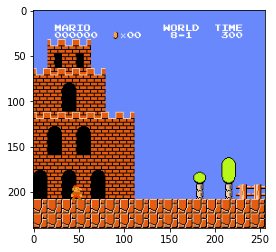

In [ ]:
plt.imshow(state)

まさにマリオのプレイ画面ですね。

### AIマリオ環境の前処理
環境に対して、前処理をしていきます。

具体的には、画像のリサイズやグレイスケール化、報酬設計の調整等です。

深層強化学習に限らず、機械学習ではこの前処理が非常に重要となります。

AIマリオ環境のフレームワークとして用いられているOpenAI Gymではカスタムラッパーを使って、環境に前処理を行っていくのがお作法となります。

以下ラッパーの説明をしていきます。

- `SkipFrame`: `gym.Wrapper`を継承し`step()`関数を実装したカスタムのラッパーです。何フレームか同じ行動をとるようにすることで、行動を簡易化しています。
- `GrayScaleObservation`: 画像をグレースケールに変換します。マリオに関しては色はそれほど重要でないと考えられるのでグレースケールを使います。色が重要なゲームでは使えない手法です。
- `ResizeEnv`: 画像をリサイズ（小さく）します。[baselinesのretro_wrappers.py](https://github.com/openai/baselines/blob/master/baselines/common/retro_wrappers.py)を参考にしました。
- `VecFrameStack`: 連続したフレームを1つにまとめるラッパーです。これで、マリオの行動をジャンプや走るといった動きとして認識できるようになります。
- `DummyVecEnv`: 学習のために必要なデータ変換となります。詳細は以下などを参照ください。これを実施すると、`env.step(1)`から`env.step([1])`といった形で、アクションの指定の形式が変わります。[こちら](https://note.com/npaka/n/n5d7d235ad8bc)や[こちら](https://kiyosucyberclub.web.fc2.com/OpenAI_Gym/Gym02-01.html)を参照ください。
- `CustomRewardAndDoneEnv`: 報酬や終了条件をカスタムするラッパーです。[こちら](https://qiita.com/hrs1985/items/871ca5d037d73558bfca)のサイトを参考に、マリオが一機死んだら終了するように変更しています。報酬の調整も可能です。

今回は、多くを独自に実装していますが、以下のようなStable Baselines3用に用意されているWrapperを使っても良いと思います。

https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html

ラッパーのインポートや定義を行います。

In [ ]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """スキップした後のフレームのみを返す"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """行動を繰り返し、報酬を合計する"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # 報酬を蓄積し、同じ行動を繰り返す
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [ ]:
class ResizeEnv(gym.ObservationWrapper):
    def __init__(self, env, size):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (size, size, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

In [ ]:
import random

class CustomRewardAndDoneEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(CustomRewardAndDoneEnv, self).__init__(env)
        self.curr_score = 0
        self.current_x = 0
        self.current_x_count = 0
        self.current_y = 0
        self.current_life = 2
        self.max_x = 0

    def reset(self):
        self.curr_score = 0
        self.current_x = 0
        self.current_x_count = 0
        self.current_y = 0
        self.current_life = 2
        self.max_x = 0

        return self.env.reset()

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        # done... flag, life 処理
        if done:
          if info["flag_get"]:
            reward += 50
            print("GOAL.", info['x_pos'], reward)
            done = True
          else:
            # print("Lost", info['x_pos'])
            reward -= 50

        # Score.
        # if info["score"] - self.curr_score > 0:
        #   reward += 1
        # reward += (info["score"] - self.curr_score) / 100.

        reward += max(0, info['x_pos'] - self.max_x)
        # reward += 1 if info['x_pos'] - self.max_x > 0 else 0

        # 同じ位置に引っかかっていたらマイナス報酬
        if (info['x_pos'] - self.current_x) == 0:
            self.current_x_count += 1
            if self.current_x_count > 20:
             reward -= 1
        else:
            self.current_x_count = 0

        # 特殊な場合
        # if self.current_x_count > 10:
        #   if ((info['y_pos'] > self.current_y) 
        #     & (self.current_y != 0) 
        #     & (info['y_pos'] > 0) 
        #     # & (info['x_pos'] > 2000)
        #   ):
        #     reward += 10

        # Update.
        self.current_y = info['y_pos']
        self.current_x = info["x_pos"]
        self.curr_score = info["score"]
        self.max_x = max(self.max_x, self.current_x)
        self.current_life = info['life']

        return state, reward / 10. , done, info


環境を再度作成して、Wrapperを適用し、前処理を行います。

In [ ]:
# MOVEMENT = [['left', 'A'], ['right', 'B'], ['right', 'A', 'B']]
env = gym_super_mario_bros.make(STAGE_NAME)
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = JoypadSpace(env, MOVEMENT)
env = CustomRewardAndDoneEnv(env)
env = SkipFrame(env, skip=SKIP_NUMB)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeEnv(env, size=84)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, STACK_FRAME_NUMB, channels_order='last')

## 環境の確認
構築した環境の確認をします。確認が不要な場合はここは飛ばしてOKです。

上記のラッパーを環境に適用すると、最終的な状態（ラップされた結果の状態）は、下図の左側の画像のように4つの連続したグレースケールのフレームを重ね合わせたものになります。

マリオが行動を取るたびに、環境はこのような構造を持つ状態を返します。

この構造は、サイズ`[1, WIDTH, HEIGHT, STACK_FRAME_NUMB]`のテンソルで表されます。

最初の1は`Dummy Vector`の分で`WIDTH, HEIGHT`がダウンサンプリングした画像のサイズ。最後の`STACK_FRAME_NUMB`連続のフレームになります。

実際の中身を見てみましょう

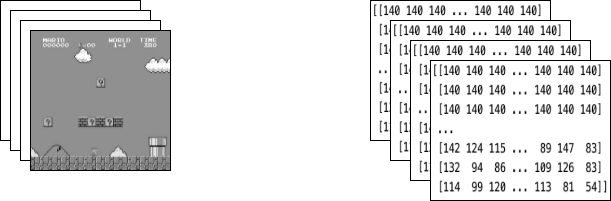

構築した環境を確認します。

In [ ]:
env.reset()
state, reward, done, info = env.step([0])

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 4)
reward: [4.]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 300, 'world': 8, 'x_pos': 40, 'y_pos': 79}]


`STACK_FRAME_NUMB`フレーム分表示します。

In [ ]:
def display_all_frame():
    plt.figure(figsize=(16,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,STACK_FRAME_NUMB,idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()

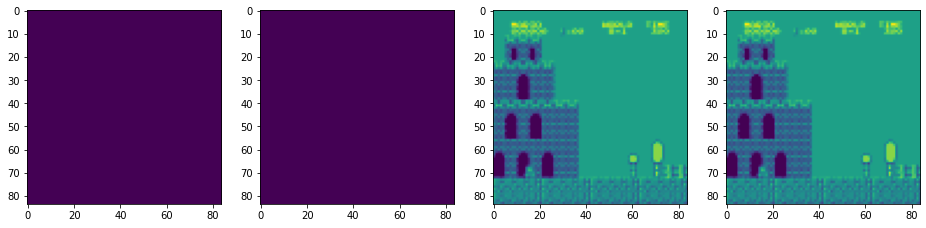

In [ ]:
display_all_frame()

In [ ]:
print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 4)
reward: [4.]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 300, 'world': 8, 'x_pos': 40, 'y_pos': 79}]


右ジャンプの操作をして表示してみます。操作に関しては以下コードで対応するアクションを確認しましょう。

- https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py

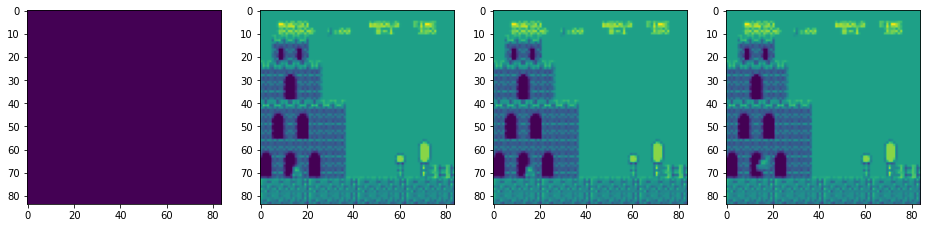

In [ ]:
state, reward, done, info = env.step([2])
display_all_frame()

In [ ]:
print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 4)
reward: [0.]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 300, 'world': 8, 'x_pos': 40, 'y_pos': 93}]


## AIマリオの学習

AIモデルの学習をします。学習済みのモデルを使う場合は、ここは飛ばして次のAIマリオのテストまで行ってください。

必要なライブラリをインポートします。

In [ ]:
# Import PPO for algos
from stable_baselines3 import PPO
import torch as th
from torch import nn

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

カスタムしたCNNを定義します。

参考：
- https://github.com/DLR-RM/stable-baselines3/blob/201fbffa8c40a628ecb2b30fd0973f3b171e6c4c/stable_baselines3/common/torch_layers.py#L51
- https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
- https://github.com/uvipen/Super-mario-bros-PPO-pytorch/blob/master/src/model.py
- https://deepblue-ts.co.jp/machine-learning/pytorch_sequential/
- https://github.com/karaage0703/karaage-ai-book/blob/master/ch02/02_karaage_ai_book_image_classification_pytorch.ipynb
- https://nobunaga.hatenablog.jp/entry/2018/09/23/171149

https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html


In [ ]:
class MarioNet(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim):
        super(MarioNet, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # # Q_target parameters are frozen.
        # for p in self.target.parameters():
        #     p.requires_grad = False

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=MarioNet,
    features_extractor_kwargs=dict(features_dim=2028),
)

# features_dimを設定してみた。len(MOVEMENT)

ログの設定をします。

In [ ]:
from pathlib import Path
import datetime
from pytz import timezone
# save_dir = Path(LOG_DIR) / datetime.datetime.now(timezone('Asia/Tokyo')).strftime("%Y-%m-%dT%H-%M-%S")
live_dir = Path(LIVE_DIR)
save_dir = live_dir
# save_dir.mkdir(parents=True)
reward_log_path = (live_dir / 'reward_log.csv')

In [ ]:
# logファイルがない場合はヘッダーを作成して保存
if not(os.path.exists(LIVE_DIR + 'reward_log.csv')):
  with open(reward_log_path, 'a') as f:
      print('timesteps,reward,best_reward', file=f)
  print('log was touched.')
  best_reward = 0

学習のコールバック関数の設定をします。

In [ ]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1, init_calls=0, best_reward = best_reward):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.n_calls = init_calls
        self.best_model = best_reward
        self.best_xpos_total = 0

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            # model_path = (save_dir / 'best_model_{}'.format(self.n_calls))
            # self.model.save(model_path)
            model_path = (self.save_path / 'live_model')
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0
            best_xpos = 0
            best_ypos = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                # while not done and total_time[i] < MAX_TIMESTEP_TEST:
                while not done:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                    if total_reward[i] > best_reward:
                        best_reward = total_reward[i]
                        best_xpos = info[0]['x_pos']
                        best_ypos = info[0]['y_pos']

                state = env.reset()  # reset for each new trial

            average_reward = sum(total_reward) / EPISODE_NUMBERS

            if max(0,  average_reward - self.best_model) > 0:
              # model_path = (live_dir / 'best_model_{}'.format(self.n_calls))
              print(' - best model:', self.n_calls)
              model_path = (self.save_path / 'best_model')
              self.model.save(model_path)
              self.best_model = average_reward

            if max(0, best_xpos - self.best_xpos_total) > 0:
              print(' - best xpos model', self.n_calls) 
              xpos_model_path = (self.save_path / 'best_xpos_model')
              self.model.save(xpos_model_path)
              self.best_xpos_total = best_xpos


            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (average_reward),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward,
                  'x_pos', best_xpos,
                  'y_pos', best_ypos)

            with open(reward_log_path, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, ',', best_reward, file=f)

        return True

学習の際、モデルを保存するコールバック関数をセットアップします。

In [ ]:
callback = TrainAndLoggingCallback(
    check_freq=CHECK_FREQ_NUMB,
    save_path=save_dir,
    init_calls =init_calls,
    best_reward = best_reward)

AIマリオのモデルを定義します。

保存されているモデルがある場合は、保存されているモデルを読み込む。新規の場合はモデルを新たに作成します。

In [ ]:
if os.path.exists(live_dir / 'live_model.zip'):
  print('loading saved model....')
  model_path = live_dir / 'live_model'
  model = PPO.load(
              model_path,
              env,
              verbose=0,
              tensorboard_log=save_dir,
              learning_rate=LEARNING_RATE,
              n_steps=N_STEPS,
              batch_size=BATCH_SIZE,
              n_epochs=N_EPOCHS,
              gamma=GAMMA,
              gae_lambda=GAE,
              ent_coef=ENT_COEF)
  # トレーニングの継続の時、pytorchのissuesに載っている問題が発生した
  # https://github.com/pytorch/pytorch/issues/80809
  model.policy.optimizer.param_groups[0]['capturable']=True
  # model.n_steps = 0
else:
  print('building a new model.')
  model = PPO(
              'CnnPolicy', 
              env,
              verbose=0,
              policy_kwargs=policy_kwargs,
              tensorboard_log=save_dir,
              learning_rate=LEARNING_RATE,
              n_steps=N_STEPS,
              batch_size=BATCH_SIZE,
              n_epochs=N_EPOCHS,
              gamma=GAMMA,
              gae_lambda=GAE,
              ent_coef=ENT_COEF)

loading saved model....


AIモデルを学習します。

In [ ]:
# %%time
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB, callback=callback)
# model.learn()

 - best xpos model 16550000
time steps: 16550000 / 20000000
average reward: 582.4600154366344 average time: 262.6 best_reward: 1022.9000278636813 x_pos 5178 y_pos 7
time steps: 16560000 / 20000000
average reward: 657.7800175279378 average time: 301.45 best_reward: 1022.3000278100371 x_pos 5175 y_pos 7
time steps: 16570000 / 20000000
average reward: 585.6650153160095 average time: 267.95 best_reward: 1020.9000279530883 x_pos 5168 y_pos 7
time steps: 16580000 / 20000000
average reward: 678.8950178280472 average time: 305.6 best_reward: 1021.3000279590487 x_pos 5170 y_pos 12
time steps: 16590000 / 20000000
average reward: 822.7850222598761 average time: 373.2 best_reward: 1021.3000279590487 x_pos 5170 y_pos 7
time steps: 16600000 / 20000000
average reward: 733.2950197886676 average time: 394.55 best_reward: 1020.9000272452831 x_pos 5168 y_pos 7
time steps: 16610000 / 20000000
average reward: 608.0950159281492 average time: 275.0 best_reward: 1022.1000270843506 x_pos 5175 y_pos 7
time step

報酬の遷移を可視化します。

In [ ]:
import pandas as pd
reward_log = pd.read_csv(reward_log_path, index_col='timesteps')
reward_log.plot()

最も良かった世代を選択します。

In [ ]:
best_epoch = reward_log['reward'].idxmax()
print('best epoch:', best_epoch)

## AIマリオのテスト

AIモデルをテストします。

### AIマリオのモデルの読み込み

#### 学習済みモデルを使用
学習済みモデルを使用する場合は、学習済みモデルを以下コマンドでダウンロードして読み込みます。

読み込んだら、次は飛ばして、AIマリオのプレイを実施してください。

In [ ]:
# !wget https://github.com/karaage0703/mario-ai-challenge/files/7926553/mario_7_1.zip

In [ ]:
# model = PPO.load('mario_7_1')

#### このノートブックで学習したモデルを使用
注：学習済みモデルを使用する場合は、ここは飛ばしてください。

このノートブックで学習したモデルを以下コマンドを実行して読み込みます。平均報酬が一番高い世代のモデルを読み込みます。

In [ ]:
best_model_path = os.path.join(live_dir, 'live_model')
model = PPO.load(best_model_path)

In [ ]:
best_epoch

#### AIマリオのプレイ
テストした結果を表示すると共に、1番良いときの画像ログデータを保存します。

テスト回数を設定

In [ ]:
EPISODE_NUMBERS = 200
MAX_TIMESTEP_TEST = 1000

In [ ]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0
    total_time[i] = 0
    frames = []
    while not done and total_time[i] < MAX_TIMESTEP_TEST:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        total_reward[i] += reward[0]
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

    # Judgement Mario goal or not
    if info[0]['flag_get']:
        print(f"<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>")
        break

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

`<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>`という表示ができたらクリアできています。

クリアできない場合は、複数回プレイして一番良いプレイ動画が保存されます。

実行のたびに結果は変わります。何回か試してみましょう。

## AIマリオのプレイ動画を保存・再生

保存した画像ログから動画を保存・再生します。

画像が多いと動画生成や確認に時間がかかるため、画像を間引きます。

画像を間引く割合を入力します（大きいほどたくさん間引きます）。

In [ ]:
SKIP_RATE = 1

画像を間引く処理をします。

In [ ]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Google Colab上で確認できる動画を生成します。生成後に再生ボタンを押すと、AIマリオのプレイ動画が見れます。

In [ ]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

動画形式で保存します。

In [ ]:
# ani.save(live_dir / 'ai_mario.mp4' ,writer="ffmpeg")

動画ファイルをダウンロードします。

In [ ]:
# from google.colab import files
# files.download('ai_mario.mp4')

GIFアニメ形式で保存します。

In [ ]:
import imageio
imageio.mimsave(live_dir / 'ai_mario.gif', [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=15)

GIFアニメをダウンロードします。

In [ ]:
# from google.colab import files
# files.download('ai_mario.gif')